In [1]:
import numpy as np
import tensorflow as tf

In [2]:
def load_mnist(path, kind='train'):
    import os

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as labels_file:
        labels = np.frombuffer(labels_file.read(), dtype=np.uint8,
                               offset=8)

    with open(images_path, 'rb') as images_file:
        images = np.frombuffer(images_file.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 28, 28)

    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

def filter_mnist(images, labels, classes):
    classes = tf.reshape(classes, [-1, 1])
    labels = tf.reshape(labels, [1, -1])

    eq = tf.equal(labels, classes)
    mask = tf.reduce_any(eq, 0)

    labels = tf.reshape(labels, [-1, 1])
    return tf.boolean_mask(images, mask), tf.boolean_mask(labels, mask)

def load_data(kind='train', path='zalando', classes=tf.constant([3, 5], dtype=tf.uint8)):
    images, labels = load_mnist(path, kind)
    return filter_mnist(images, labels, classes)

2021-10-24 01:00:42.806747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
train_images, train_labels = load_data()
test_images, test_labels = load_data(kind='t10k')

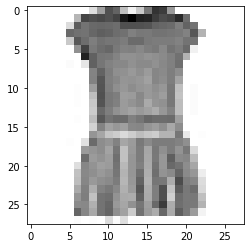

In [4]:
import matplotlib.pyplot as plt

img = 1.0 - train_images[0].numpy() / 255.0
plt.imshow(img, cmap='gray')

In [13]:
def normalize(images):
    casted = tf.cast(tf.reshape(images, (images.shape[0], -1)), dtype=tf.float32)
    norm = tf.linalg.norm(casted, axis=1)

    return casted / tf.reshape(norm, [-1, 1])

def map_labels(labels, zero_class=3):
    condition = tf.equal(labels, tf.constant(zero_class, shape=labels.shape, dtype=tf.uint8))
    zeros = tf.zeros(labels.shape)
    ones = tf.ones(labels.shape)

    return tf.where(condition, zeros, ones)

def preprocess(images, labels):
    return normalize(images), map_labels(labels)

In [19]:
train_images_norm, train_labels_norm = preprocess(train_images, train_labels)
test_images_norm, test_labels_norm = preprocess(test_images, test_labels)

In [73]:
from tensorflow import keras

class LinearWithSigmoid(keras.layers.Layer):
    def __init__(self, input_dims, output_dims):
        super(LinearWithSigmoid, self).__init__()

        w_init = tf.random_uniform_initializer(-1.0, 1.0)
        self.w = tf.Variable(
            initial_value=w_init(shape=[input_dims, output_dims], dtype=tf.float32),
            trainable=True
        )

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(output_dims,), dtype=tf.float32),
            trainable=True
        )

    def call(self, inputs):
        return tf.math.sigmoid(tf.matmul(inputs, self.w) + self.b)

In [74]:
x = test_images_norm

layer = LinearWithSigmoid(28 * 28, 1)
layer(x)

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[0.46106637],
       [0.37812367],
       [0.2730239 ],
       ...,
       [0.49577102],
       [0.59936965],
       [0.5709743 ]], dtype=float32)>

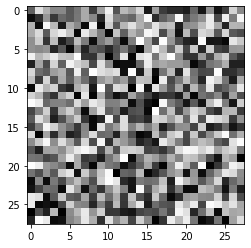

In [75]:
img = tf.reshape(layer.w, shape=[28, 28]).numpy()
plt.imshow(img, cmap='gray')

In [82]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model = keras.Sequential([
    LinearWithSigmoid(28 * 28, 1)
])

model.compile(loss=loss_fn,optimizer=optimizer, metrics=[keras.metrics.BinaryAccuracy()])
x, y = train_images_norm, train_labels_norm
history = model.fit(x, y, epochs=10)

Epoch 1/10
375/375 [==============================] - 1s 1ms/step - loss: 0.3920 - binary_accuracy: 0.9198
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 

In [83]:
x_test, y_test = test_images_norm, test_labels_norm

model.evaluate(x_test, y_test)


63/63 [==============================] - 0s 1ms/step - loss: 0.0410 - binary_accuracy: 0.9940


[0.0410090871155262, 0.9940000176429749]

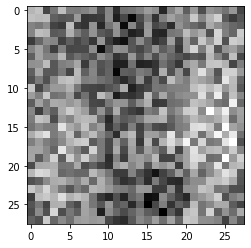

In [97]:
w = model.layers[0].get_weights()[0]
w = tf.convert_to_tensor(w)
w = tf.reshape(w, shape=[28, 28])

img = tf.reshape(w, shape=[28, 28]).numpy()
plt.imshow(img, cmap='gray')

In [98]:
# Playground.
# test_labels_norm.dtype
# cross entropy implemntation sketch below
y_true = test_labels_norm

# tf.one_hot(test_labels_norm, depth=2)
yh_true = tf.concat([y_true, 1 - y_true], axis=1)
yh_true.shape

yh_pred = tf.concat([y_true, 1 - y_true], axis=1)
yh_pred = tf.clip_by_value(yh_pred, 1e-9, 1.0)

tf.reduce_mean(-tf.reduce_sum(yh_true * tf.math.log(yh_pred)))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [ ]:
# Logistic regression (Wx + b).
def logistic_regression(x):
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.

def cross_entropy(y_pred, y_true):

    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=2)

    y_true = tf.constant([y_true, 1 - y_true])

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))



In [105]:
classes = tf.constant([3, 5], dtype=tf.int32)
classes = tf.reshape(classes, [-1, 1])
labels = tf.constant([1, 3, 2, 5, 4])
labels = tf.reshape(labels, [1, -1])

res = tf.equal(labels, classes)
reduced = tf.reduce_any(res, 0)

res = map_labels(labels)
res



<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[1., 0., 1., 1., 1.]], dtype=float32)>